In [58]:
import pandas as pd
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import precision_score, accuracy_score, recall_score
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import GridSearchCV

# Create learning dataset

In [2]:
dataset = pd.read_csv("../data/ready_to_use_datasets/lesfresnes.csv")

In [3]:
dataset["date"] = pd.to_datetime(dataset["date"])

In [61]:
X = dataset.drop(["reference_pm25", "microsensor_pm25", "date", "season"], axis=1)

In [68]:
X

,hourofday,monthofyear,temperature,humidity
0,0,1,13.21,99.9
1,0,1,13.21,99.9
2,0,1,12.92,99.9
3,0,1,12.92,99.9
4,0,1,13.21,99.9
...,...,...,...,...
753065,13,12,7.20,99.9
753066,13,12,7.20,99.9
753067,13,12,7.61,99.9
753068,13,12,7.61,99.9


## Construct labels

A microsensor measure is labeled wrong if the absolute difference with the reference station exceeds an arbitrarily chosen threshold.

In [62]:
# Construct labels
threshold = 3
y = abs(dataset["reference_pm25"] - dataset["microsensor_pm25"]) >= threshold

## Split training and testing sets

In [63]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, shuffle=True)

In [64]:
true_propor = sum(y_train) / len(y_train)
print(f"{round(true_propor * 100, 2)}% of the training measures are labeled as wrong.")

27.87% of the training measures are labeled as wrong.


In [65]:
balancer = SMOTE()
X_train, y_train = balancer.fit_resample(X_train, y_train)

In [66]:
true_propor = sum(y_train) / len(y_train)
print(f"{round(true_propor * 100, 2)}% of the training measures are labeled as wrong after the SMOTE resampling.")

50.0% of the training measures are labeled as wrong after the SMOTE resampling.


# Train the model

## Grid search

In [71]:
# Define parameter grid
param_grid = {
    "learning_rate": [0.1],
    "max_depth": [4, 8],
    "min_child_weight": [1, 5, 10],
    "gamma": [0, 0.1, 0.3],
    "n_estimators": [200]
}

# Initialize the classifier with fixed parameters
clf = xgb.XGBClassifier(tree_method="hist", early_stopping_rounds=4, use_label_encoder=False)

In [72]:
# Set up GridSearchCV
grid_search = GridSearchCV(
    estimator=clf,
    param_grid=param_grid,
    scoring="f1",
    cv=3,              
    verbose=1,
    n_jobs=-1 
)

grid_search.fit(X_train, y_train, eval_set=[(X_train, y_train)], verbose=False)

Fitting 3 folds for each of 18 candidates, totalling 54 fits


/home/exbrayaj/.cache/pypoetry/virtualenvs/atmo-challenge-3vYJEt9I-py3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [13:55:41] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/exbrayaj/.cache/pypoetry/virtualenvs/atmo-challenge-3vYJEt9I-py3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [13:55:42] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/exbrayaj/.cache/pypoetry/virtualenvs/atmo-challenge-3vYJEt9I-py3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [13:55:42] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/exbrayaj/.cache/pypoetry/virtualenvs/atmo-challenge-3vYJEt9I-py3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [13:55:42] WARNING: /workspace/src/lea

GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=4,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             n_jobs=-1,
             param_grid={'gamma': [0, 0.1, 0.3], 'learning_rate': [0.1],
                         'max_depth': [4, 8], 'min_child_weight': [1, 5, 10],
                         'n_estimators': [200]},
             scoring='f1', verbose=1)

In [73]:
print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

Best parameters: {'gamma': 0, 'learning_rate': 0.1, 'max_depth': 8, 'min_child_weight': 1, 'n_estimators': 200}
Best score: 0.6979292018909868


## Final training

In [74]:
best_params = grid_search.best_params_
optimized_clf = xgb.XGBClassifier(tree_method="hist", early_stopping_rounds=4, **best_params)
optimized_clf.fit(X_train, y_train, eval_set=[(X_train, y_train)])

[0]	validation_0-logloss:0.68334
[1]	validation_0-logloss:0.67504
[2]	validation_0-logloss:0.66817
[3]	validation_0-logloss:0.66252
[4]	validation_0-logloss:0.65755
[5]	validation_0-logloss:0.65358
[6]	validation_0-logloss:0.64980
[7]	validation_0-logloss:0.64606
[8]	validation_0-logloss:0.64310
[9]	validation_0-logloss:0.64032
[10]	validation_0-logloss:0.63775
[11]	validation_0-logloss:0.63581
[12]	validation_0-logloss:0.63375
[13]	validation_0-logloss:0.63152
[14]	validation_0-logloss:0.62939
[15]	validation_0-logloss:0.62750
[16]	validation_0-logloss:0.62606
[17]	validation_0-logloss:0.62459
[18]	validation_0-logloss:0.62316
[19]	validation_0-logloss:0.62191
[20]	validation_0-logloss:0.62089
[21]	validation_0-logloss:0.61960
[22]	validation_0-logloss:0.61842
[23]	validation_0-logloss:0.61745
[24]	validation_0-logloss:0.61642
[25]	validation_0-logloss:0.61530
[26]	validation_0-logloss:0.61455
[27]	validation_0-logloss:0.61365
[28]	validation_0-logloss:0.61296
[29]	validation_0-loglos

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=4,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=8, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

# Analyse model

## Metrics

In [75]:
y_pred = optimized_clf.predict(X_test)

In [76]:
print(f"Precision: {precision_score(y_test, y_pred)}")
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(f"Recall: {recall_score(y_test, y_pred)}")

Precision: 0.45935589588454023
Accuracy: 0.6855546348821893
Recall: 0.6908494625694299


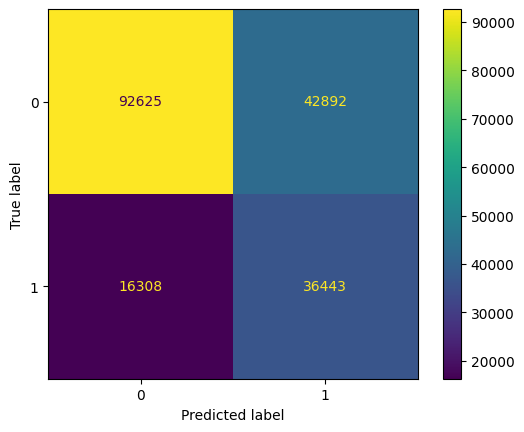

In [77]:
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm).plot()

In [78]:
print(f"Proportion of predicted positive: {sum(y_pred) / len(y_pred)}")

Proportion of predicted positive: 0.4213939702976608


## Comparison with dummy classifier

In [79]:
dummy_model = DummyClassifier(strategy='uniform')
dummy_model.fit(X_test, y_test)
dummy_pred = dummy_model.predict(X_test)
print(f"Precision: {precision_score(y_test, dummy_pred)}")
print(f"Accuracy: {accuracy_score(y_test, dummy_pred)}")
print(f"Recall: {recall_score(y_test, dummy_pred)}")

Precision: 0.27964298631944
Accuracy: 0.4997609790298936
Recall: 0.49832230668612915


## Feature importance

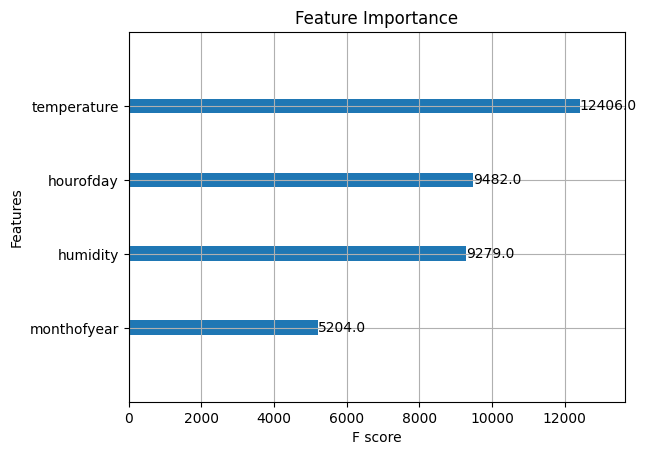

In [81]:
xgb.plot_importance(optimized_clf, importance_type='weight')
plt.title('Feature Importance')
plt.show()